In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV
import joblib

class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch:
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._claculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _claculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparition (higest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, quesion, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=quesion[0], threshold=quesion[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

In [7]:
class RandomForestClassifierFromScratch:
  def __init__(self, max_feature=None, n_trees=100, min_sample_split=2, min_impurity=1e-7, max_depth=10, criterion='gini'):
    # Initialize the trees.
    self.trees = []
    for _ in range(n_trees):
      self.trees.append(DecisionTreeClassifierFromScratch(min_sample_split=min_sample_split,min_impurity=min_impurity,
                                                          max_depth=max_depth,criterion=criterion))

    self.tree_feature_indexes = []
    # Number of trees/estimetors.
    self.n_estimators = n_trees
    # How many features can be used for a tree from the whole features.
    self.max_features = max_feature
    # Aggication function to find the prediction.
    self.prediction_aggrigation_calculation = self._maximum_vote_calculation

  def _maximum_vote_calculation(self, y_preds):
    # Find which prediction class has higest frequency in all tree prediction for each sample.
    # create a empty array to store the prediction.
    y_pred = np.empty((y_preds.shape[0], 1))
    # iterate over all the data samples.
    for i, sample_predictions in enumerate(y_preds):
      y_pred[i] = np.bincount(sample_predictions.astype('int')).argmax()

    return y_pred

  def _make_random_subset(self, X, y, n_subsets, replacement=True):
    # Create a random subset of dataset with/without replacement.
    subset = []
    # use 100% of data when replacement is true , use 50% otherwise.
    sample_size = (X.shape[0] if replacement else (X.shape[0] // 2))

    # Add y as last column of X
    Xy = np.column_stack((X, y))
    np.random.shuffle(Xy)
    # Select randome subset of data with replacement.
    for i in range(n_subsets):
      index = np.random.choice(range(sample_size), size=np.shape(range(sample_size)), replace=replacement)
      X = Xy[index][:, :-1]
      y = Xy[index][: , -1]
      subset.append({"X" : X, "y": y})
    return subset

  def fit(self, X, y):
    # if the max_features is not given then select it as square root of no on feature availabe.
    n_features = X.shape[1]
    if self.max_features == None:
      self.max_features = int(round(np.sqrt(n_features)))

    # Split the dataset into number of subsets equal to n_estimators.
    subsets = self._make_random_subset(X, y, self.n_estimators)

    for i, subset in enumerate(subsets):
      X_subset , y_subset = subset["X"], subset["y"]
      # select a random sucset of features for each tree. This is called feature bagging.
      idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
      # track this for prediction.
      self.tree_feature_indexes.append(idx)
      # Get the X with the selected features only.
      X_subset = X_subset[:, idx]

      # change the y_subet to i dimentional array.
      y_subset = np.expand_dims(y_subset, axis =1)
      # build the model with selected features and selected random subset from dataset.
      self.trees[i].fit(X_subset, y_subset)

  def predict(self, test_X):
    y_preds = np.empty((test_X.shape[0], self.n_estimators))
    # find the prediction from each tree for each samples
    for i, tree in enumerate(self.trees):
      features_index = self.tree_feature_indexes[i]
      X_selected_features = test_X[:, features_index]
      if isinstance(tree, DecisionTreeClassifierFromScratch):
        y_preds[:, i] = tree.predict(X_selected_features).reshape((-1,))
      else:
        y_preds[:, i] = tree.predict(X_selected_features)
    # find the aggregated output.
    y_pred = self.prediction_aggrigation_calculation(y_preds)

    return y_pred

In [8]:
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')
df.drop(columns=['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'], inplace=True)
df.head()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [9]:
# Look if there are any duplicate rows in the dataset
df.loc[df.duplicated()]

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation


In [10]:
# Check for null values
df.isna().sum()

fuel_consumption_rate              0
eta_variation_hours                0
traffic_congestion_level           0
warehouse_inventory_level          0
loading_unloading_time             0
handling_equipment_availability    0
order_fulfillment_status           0
weather_condition_severity         0
port_congestion_level              0
shipping_costs                     0
supplier_reliability_score         0
lead_time_days                     0
historical_demand                  0
iot_temperature                    0
cargo_condition_status             0
route_risk_level                   0
customs_clearance_time             0
driver_behavior_score              0
fatigue_monitoring_score           0
disruption_likelihood_score        0
delay_probability                  0
risk_classification                0
delivery_time_deviation            0
dtype: int64

In [11]:
numerical_list = [x for x in df.columns if df[x].dtype in ('int64','float64')]
print(numerical_list)

['fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'port_congestion_level', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'driver_behavior_score', 'fatigue_monitoring_score', 'disruption_likelihood_score', 'delay_probability', 'delivery_time_deviation']


In [12]:
#Removal of outlier:

df1 = df.copy()

for i in numerical_list:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
# display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
df = df1.copy()
df.head()


Inference:
Before removal of outliers, The dataset had 32065 samples.
After removal of outliers, The dataset now has 25245 samples.


,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [13]:
# Label encoding

label_encoder = LabelEncoder()
df['risk_classification'] = label_encoder.fit_transform(df['risk_classification'])

In [14]:
# target class are highly imbalanced
df['risk_classification'].value_counts()

risk_classification
0    20451
2     4277
1      517
Name: count, dtype: int64

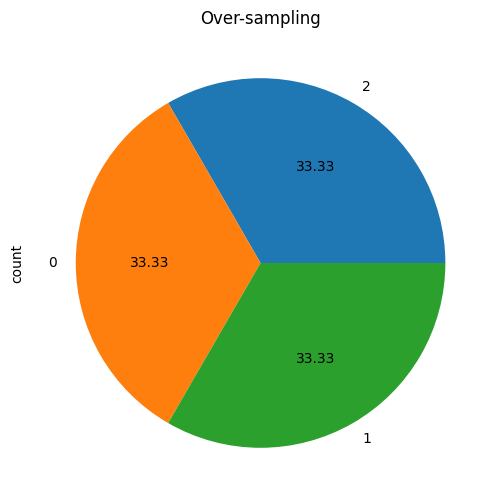

In [15]:
# solve imbalnce class

#Random Oversampling
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy="not majority") # String
# X = df.drop(['risk_classification'], axis=1)
# Y = df['risk_classification']
# X, Y = ros.fit_resample(X, Y)

# ------------------------------------------------------------

# Apply SMOTE (Synthetic Minority Over-sampling)
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["risk_classification"])  # Features
Y = df["risk_classification"]  # Target
smote = SMOTE(sampling_strategy="auto", random_state=42)
X, Y = smote.fit_resample(X, Y)

ax = Y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [16]:
# after solve imbalnce class
Y.value_counts()

risk_classification
2    20451
0    20451
1    20451
Name: count, dtype: int64

In [17]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

#  Select Features Using Information Gain For Classification In ML

from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.03572653, 0.03287907, 0.0264211 , 0.02363372, 0.02880101,
       0.02967646, 0.03861522, 0.02840366, 0.03509902, 0.02091369,
       0.03120255, 0.03493233, 0.04906425, 0.03262461, 0.03744646,
       0.02849104, 0.02599664, 0.03713994, 0.03534458, 1.09861532,
       0.03246384, 0.03816075])

In [18]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

disruption_likelihood_score        1.098615
historical_demand                  0.049064
order_fulfillment_status           0.038615
delivery_time_deviation            0.038161
cargo_condition_status             0.037446
driver_behavior_score              0.037140
fuel_consumption_rate              0.035727
fatigue_monitoring_score           0.035345
port_congestion_level              0.035099
lead_time_days                     0.034932
eta_variation_hours                0.032879
iot_temperature                    0.032625
delay_probability                  0.032464
supplier_reliability_score         0.031203
handling_equipment_availability    0.029676
loading_unloading_time             0.028801
route_risk_level                   0.028491
weather_condition_severity         0.028404
traffic_congestion_level           0.026421
customs_clearance_time             0.025997
warehouse_inventory_level          0.023634
shipping_costs                     0.020914
dtype: float64

<Axes: >

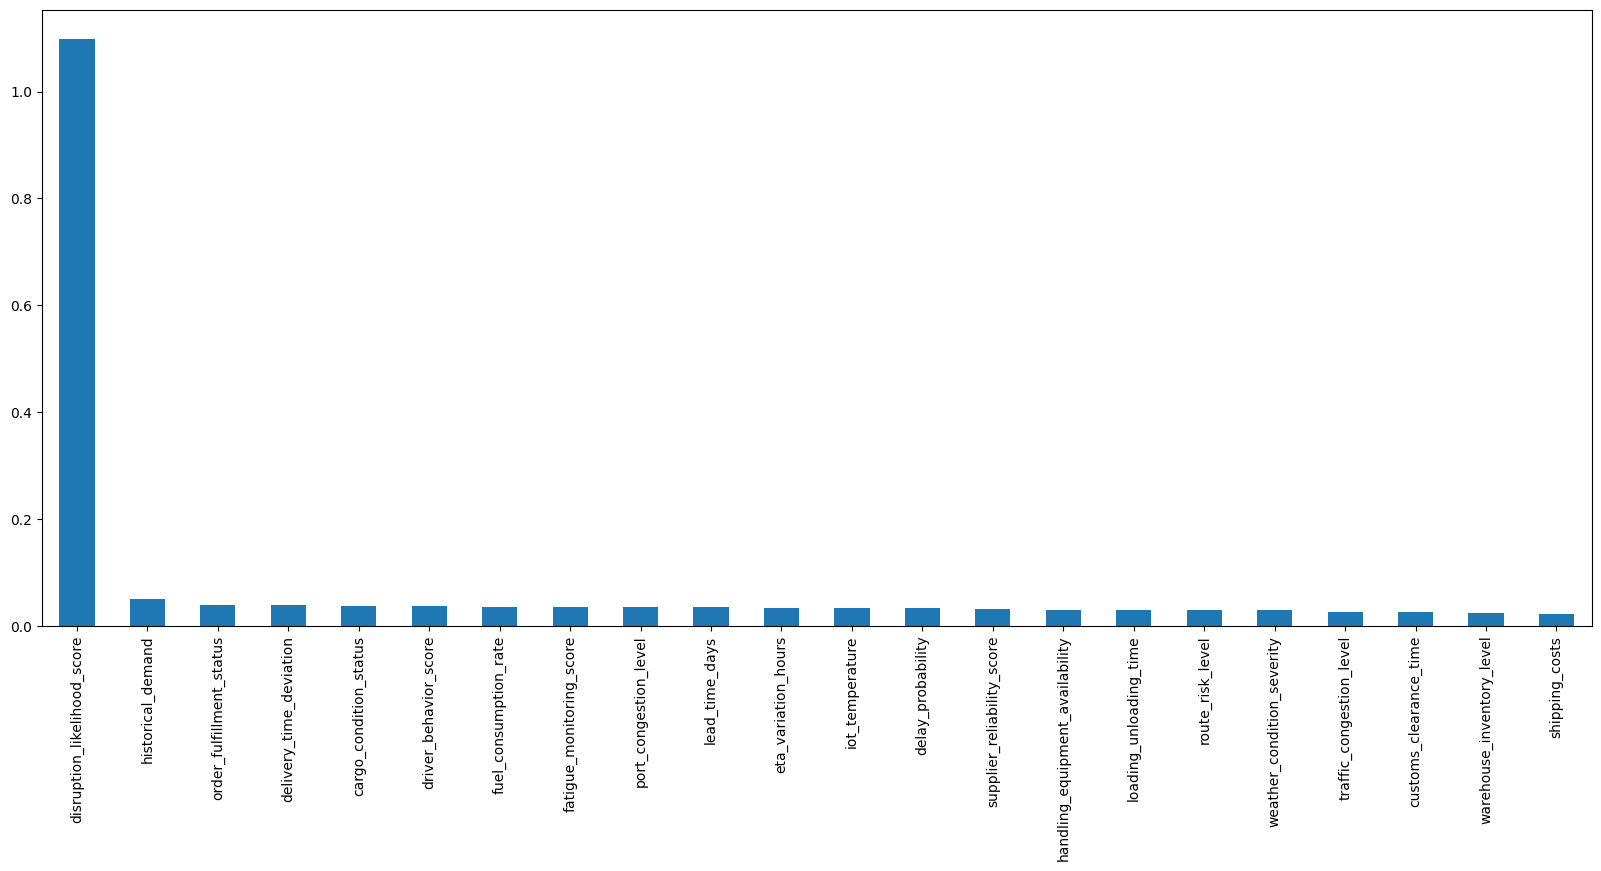

In [19]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [20]:
from sklearn.feature_selection import SelectKBest

#No we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
selected_feature = X_train.columns[sel_five_cols.get_support()]
print(f"Top 5 Feature: {selected_feature}")

Top 5 Feature: Index(['order_fulfillment_status', 'historical_demand',
       'cargo_condition_status', 'disruption_likelihood_score',
       'delivery_time_deviation'],
      dtype='object')


In [21]:
X_train = X_train[selected_feature]
X_test = X_test[selected_feature]

X_train

,order_fulfillment_status,historical_demand,cargo_condition_status,disruption_likelihood_score,delivery_time_deviation
24481,0.882777,7205.246476,0.035134,1.000000,2.348545
58434,0.247370,7995.285807,0.594477,0.562096,8.768822
22492,0.756477,9932.483769,0.477842,0.776728,9.828261
39689,0.318124,9957.979009,0.194927,0.268893,7.516259
2888,0.916517,2104.904816,0.722561,0.999998,1.697481
...,...,...,...,...,...
54343,0.461909,9966.174332,0.076690,0.487871,6.648762
38158,0.930660,4601.759031,0.754161,0.292436,-0.352302
860,0.632656,8251.035573,0.217659,0.953890,3.389473
15795,0.853349,9967.005582,0.937680,0.999965,9.107156


In [22]:
# Transform data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)
X_test_scaled = scaler.transform(X_test)

[[0.88277692 0.71770158 0.03513418 0.9999999  0.36237853]
 [0.24736903 0.79750356 0.59447666 0.42515965 0.89740183]
 [0.7564762  0.99318018 0.47784152 0.70690859 0.98568843]
 ...
 [0.6326551  0.82333687 0.21765886 0.9394711  0.4491226 ]
 [0.85334865 0.99666723 0.93767998 0.99995409 0.9255963 ]
 [0.6650766  0.73330631 0.01289791 0.14487667 0.67038991]]


In [ ]:
# From Scratch
rf = RandomForestClassifierFromScratch(n_trees=50, criterion="entropy")
rf.fit(X_train_scaled, y_train)
sc_rf_pred = rf.predict(X_test_scaled)

accuracy_score(y_test, sc_rf_pred)

# n_trees=10  accuracy = 0.8046808788056588, time =  76m 26.2s
# n_trees=50  accuracy = 0.8746984809961535, time = 303m  8.4s
# n_trees=100 accuracy = 0.8487515483408306, time = 575m 37.9s

In [ ]:
# save model
joblib.dump(rf, 'model_randomforest50.joblib')

In [29]:
# load model to use for evaluation
path_to_model = 'model_randomforest50.joblib'
model_randomforest100_loaded = joblib.load(path_to_model)
y_pred = model_randomforest100_loaded.predict(X_test_scaled)

In [30]:
# Begin Evaluation (classification)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Classification Report
print("classification report : ")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix : ")
print(cm)

classification report : 
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5011
           1       0.76      0.99      0.86      5181
           2       0.99      0.77      0.86      5147

    accuracy                           0.87     15339
   macro avg       0.90      0.87      0.88     15339
weighted avg       0.90      0.87      0.88     15339

Confusion Matrix : 
[[4346  624   41]
 [  59 5120    2]
 [ 241  955 3951]]


In [31]:
# Precision, Recall (Sensitivity), and F1-score for multiclass
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")  # Precision (average the results across all classes)
recall = recall_score(y_test, y_pred, average="macro")  # Sensitivity (average the results across all classes)
f1 = f1_score(y_test, y_pred, average="macro")  # F1-score (average the results across all classes)

# Compute Specificity for each class
specificity_list = []
for i in range(len(cm)):
    TP = cm[i, i]
    FN = sum(cm[i, :]) - TP
    FP = sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    specificity_list.append(specificity)

specificity_macro = np.mean(specificity_list)  # Macro-averaged specificity

# Metrics (averages scores equally across all classes)
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision (Macro): {precision:.4f}')
print(f'Sensitivity (Recall, Macro): {recall:.4f}')
print(f'Specificity (Macro): {specificity_macro:.4f}')
print(f'F1-Score (Macro): {f1:.4f}')

Accuracy : 0.8747
Precision (Macro): 0.8963
Sensitivity (Recall, Macro): 0.8744
Specificity (Macro): 0.9371
F1-Score (Macro): 0.8755


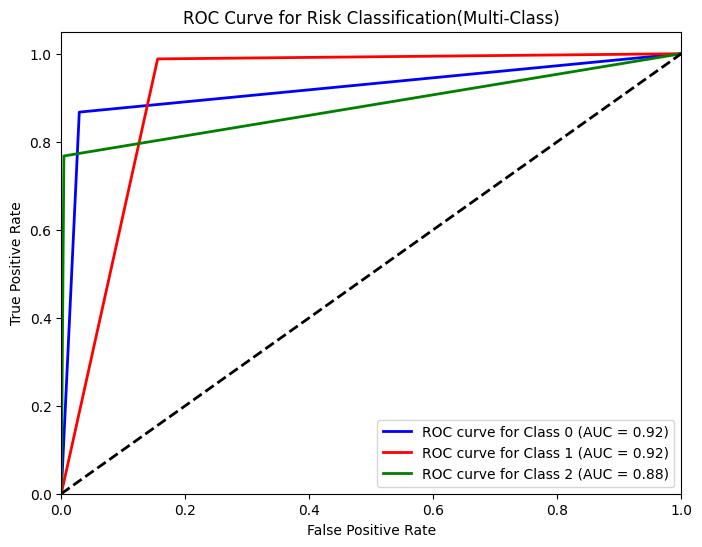

In [32]:
# Compute ROC curve and ROC AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC
# In the case of multiclass classification, a notion of TPR or FPR is obtained only after binarizing the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

n_classes = y_test_bin.shape[1]
# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Risk Classification(Multi-Class)')
plt.legend(loc="lower right")
plt.show()